## This notebook studies the stochasitcity of the crossbar model

In [3]:
import sys
sys.path.append("..")

In [4]:
import matplotlib.pyplot as plt
from memristor.devices import StaticMemristor, DynamicMemristor, DynamicMemristorFreeRange, DynamicMemristorStuck
from memristor.crossbar.model import LineResistanceCrossbar
import torch
from tqdm import tqdm
import numpy as np

#### First, find appropriate programming voltage for each bitline and wordline to ensure v_p is within range

range [−0.8 V to −1.5 V]/[0.8 V to 1.15 V]

In [5]:
torch.set_default_dtype(torch.float64) # set default torch value type

In [6]:
def plot_voltage_drop(crossbar, v_wl_applied, v_bl_applied, imshow=True):
    ideal_range = []
    crossbar.lineres_memristive_vmm(v_wl_applied, v_bl_applied, iter=1)
    M = torch.t(crossbar.cache["V_wl"]-crossbar.cache["V_bl"])
    if imshow:
        im = plt.imshow(M,
                        interpolation='none', aspect='equal')
        ax = plt.gca()
        # no need for axis
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title("Cell voltage TiOx crossbar")
        ax.grid(which='minor', color='w', linestyle='-', linewidth=1)
        plt.colorbar()
        plt.show()
    # show % within range
    bt1 = torch.numel(M[(-1.5<=M) & (M<=-0.8)])/torch.numel(M)
    bt2 = torch.numel(M[(0.8<=M) & (M<=1.15)])/torch.numel(M)
    if imshow:
        print(f"percent memristor cell voltage in range [−0.8 V to −1.5 V]/[0.8 V to 1.15 V]: {100*max(bt1, bt2)}%:")
    return 100*max(bt1, bt2)

In [7]:
crossbar_params = {'r_wl': 20, 'r_bl': 20, 'r_in':10, 'r_out':10, 'V_SOURCE_MODE':'|_|'}
memristor_model = DynamicMemristorStuck
memristor_params = {'frequency': 1e8, 'temperature': 273 + 40}
ideal_w = 70*torch.ones(48, 16)*1e-6

In [8]:
crossbar = LineResistanceCrossbar(memristor_model, memristor_params, ideal_w, crossbar_params)

/Users/jvjv/Github/pytorch-metal-oxide-memristor-crossbar/Notebooks/../memristor/devices.py:54: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.g_linfit, _, _, _ = np.linalg.lstsq(np.reshape(np.linspace(-0.4, 0.4, 50), [50,1]),
/Users/jvjv/Github/pytorch-metal-oxide-memristor-crossbar/Notebooks/../memristor/crossbar/model.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/pytorch/torch/csrc/utils/tensor_new.cpp:210.)
  self.fitted_w = torch.tensor([[self.memristors[i][j].g_linfit for j in range(ideal_w.shape[1])]


In [9]:
best_v_wl_applied = 1.3 * torch.concat([1.2*torch.ones(12,), torch.linspace(1.2, 1, 4)], dim=0)#torch.concat([3.1*torch.ones(12,), torch.linspace(3.1, 2.4,4)], dim=0)
best_v_bl_applied = 1.5 * torch.concat([torch.linspace(1, 1.2,16), 1.2*torch.ones(16,),torch.linspace(1.2, 1,16)], dim=0)

##### Reset operation cell voltage drop

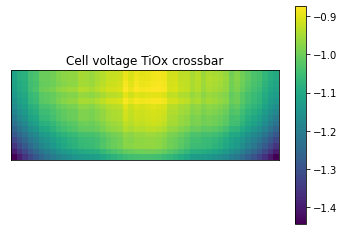

percent memristor cell voltage in range [−0.8 V to −1.5 V]/[0.8 V to 1.15 V]: 100.0%:


100.0

In [10]:
plot_voltage_drop(crossbar, 0*torch.ones(16,), best_v_bl_applied)

##### Set operation cell voltage drop

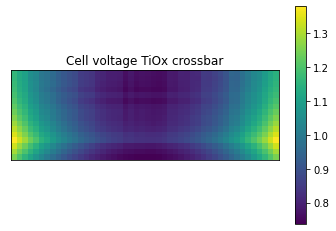

percent memristor cell voltage in range [−0.8 V to −1.5 V]/[0.8 V to 1.15 V]: 67.1875%:


67.1875

In [11]:
plot_voltage_drop(crossbar, best_v_wl_applied, 0*torch.ones(48,))

#### Now we can apply the first set of programming voltage

In [14]:
def program_crossbar(crossbar, v_wl_applied, v_bl_applied, t_p, iterations, imshow=True):
    ideal_w_hist=[torch.clone(crossbar.ideal_w).view(-1)]
    fitted_w_hist=[torch.clone(crossbar.fitted_w).view(-1)]
    for i in range(iterations):
        #  program the crossbar
        crossbar.lineres_memristive_programming(v_wl_applied, v_bl_applied, t_p)
        ideal_w_hist.append(torch.clone(crossbar.ideal_w).view(-1))
        fitted_w_hist.append(torch.clone(crossbar.fitted_w).view(-1))
    if imshow:
        # conductance change history
        ideal_w_hist = torch.stack(ideal_w_hist, dim=1)
        fitted_w_hist = torch.stack(fitted_w_hist, dim=1)
        
        for i in range(ideal_w_hist.shape[0]):
            plt.plot(range(iterations + 1), ideal_w_hist[i, :]*1e6)
        plt.title("ideal conductance change")
        plt.ylabel("conductance (uS)")
        plt.ylim([0, 300])
        plt.show()
        
        for i in range(fitted_w_hist.shape[0]):
            plt.plot(range(iterations + 1), fitted_w_hist[i, :]*1e6)
        plt.title("fitted conductance change")
        plt.ylabel("conductance (uS)")
        plt.ylim([0, 300])
        plt.show()
        
def crossbar_statistics(crossbar, txt=""):
    print(txt)
    plt.matshow(torch.t(crossbar.ideal_w)*1e6)
    plt.title("ideal conductance")
    plt.colorbar()
    plt.show()
    # best fit conductance
    plt.matshow(torch.t(crossbar.fitted_w)*1e6)
    plt.title("fitted conductance")
    plt.colorbar()
    plt.show()

    # Histograms
    hist, bins = np.histogram(crossbar.ideal_w, bins=100)
    plt.plot(bins[:-1]*1e6, hist)
    plt.title("ideal conductance histogram")
    plt.xlabel("conductance (uS)")
    plt.xlim([0, 150])
    plt.show()

    hist, bins = np.histogram(crossbar.fitted_w, bins=100)
    plt.plot(bins[:-1]*1e6, hist)
    plt.title("fitted conductance histogram")
    plt.xlabel("conductance (uS)")
    plt.xlim([0, 150])
    plt.show()
    
    #stuck memristors
    stuck_mask = [[0 if crossbar.memristors[i][j].stuck else 1 for j in range(ideal_w.shape[1])] for i in range(ideal_w.shape[0])]
    stuck_mask = torch.t(torch.tensor(stuck_mask))
    plt.title("stuck memristors")
    plt.matshow(stuck_mask)
    plt.colorbar()
    plt.show()

    print("reset in range:", plot_voltage_drop(crossbar, 0*torch.ones(16,), best_v_bl_applied, imshow=False))
    print("set in range:", plot_voltage_drop(crossbar, best_v_wl_applied, 0*torch.ones(48,), imshow=False))

Before first iteration:

Before 1st reset programming (uS)


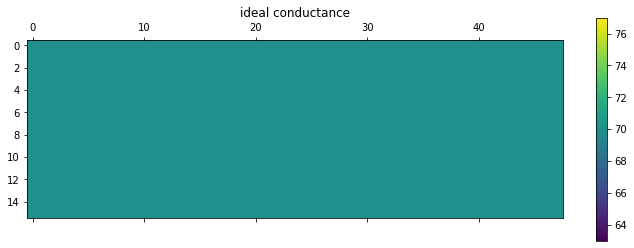

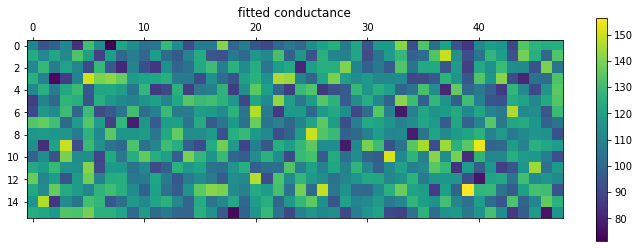

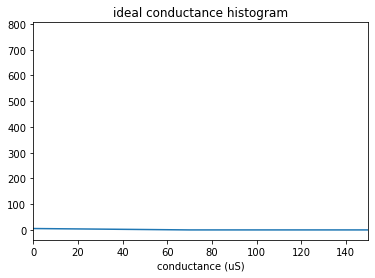

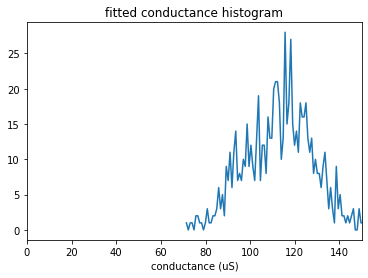

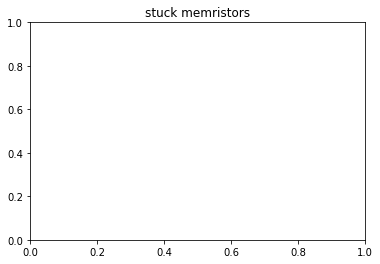

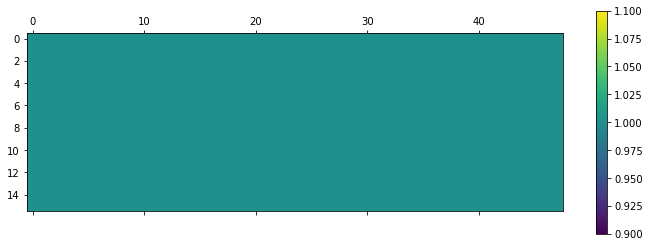

reset in range: 100.0
set in range: 67.1875


In [15]:
crossbar_statistics(crossbar, txt="Before 1st reset programming (uS)")

First set Programming

In [16]:
t_p = 0.5e-3 # programming pulse duration
iterations = 40
program_crossbar(crossbar, 0*torch.ones(16,), best_v_bl_applied, t_p, iterations)

TypeError: unsupported operand type(s) for +: 'type' and 'str'

After first iteration

After 1st reset programming (uS)


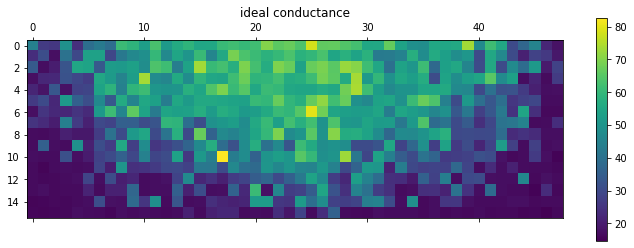

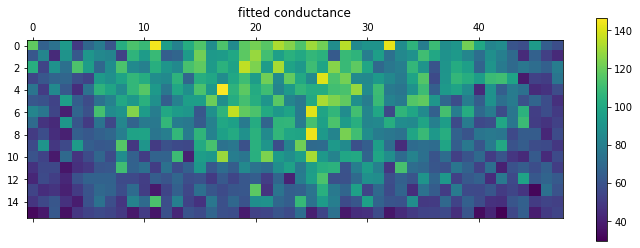

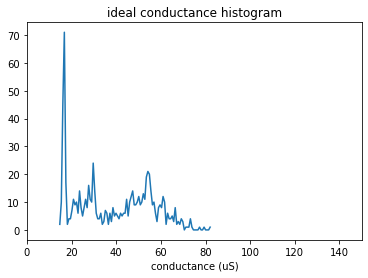

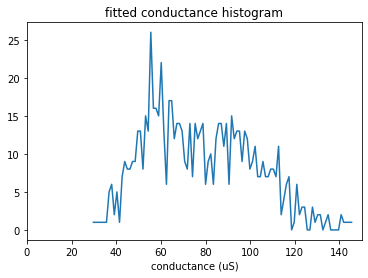

reset in range: 100.0
set in range: 70.44270833333334


In [13]:
crossbar_statistics(crossbar, txt="After 1st reset programming (uS)")

First Set Programming

/Users/jvjv/Github/pytorch-metal-oxide-memristor-crossbar/Notebooks/../memristor/devices.py:54: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.g_linfit, _, _, _ = np.linalg.lstsq(np.reshape(np.linspace(-0.4, 0.4, 50), [50,1]),
/Users/jvjv/Github/pytorch-metal-oxide-memristor-crossbar/Notebooks/../memristor/crossbar/model.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ideal_w[i,j] = torch.tensor(self.memristors[i][j].g_0)


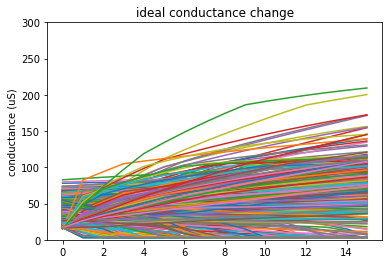

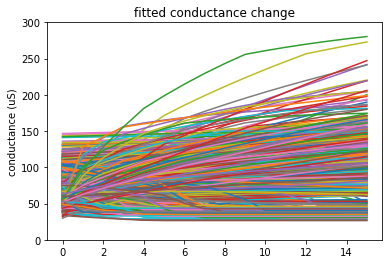

In [14]:
t_p = 0.25e-3 # programming pulse duration
iterations = 15
program_crossbar(crossbar, best_v_wl_applied, 0*torch.ones(48,), t_p, iterations)

After 1st set programming (uS)


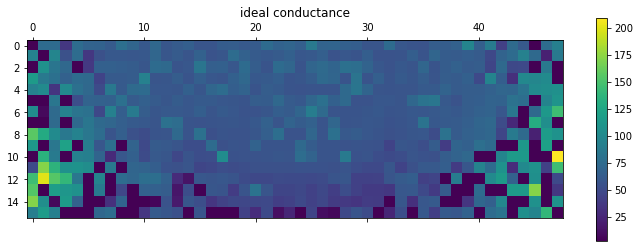

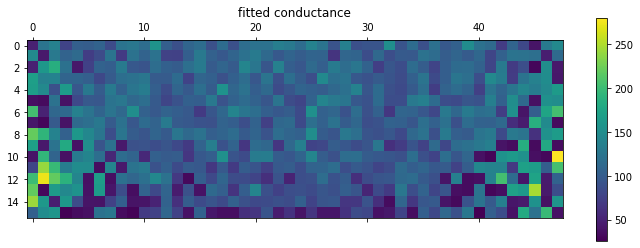

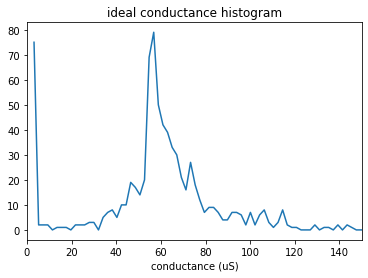

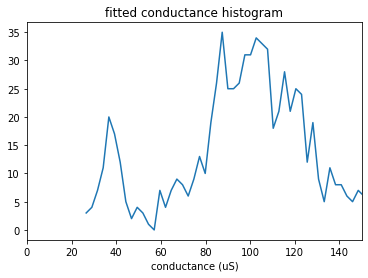

reset in range: 100.0
set in range: 79.94791666666666


In [15]:
crossbar_statistics(crossbar, txt="After 1st set programming (uS)")

Second Reset voltage

/Users/jvjv/Github/pytorch-metal-oxide-memristor-crossbar/Notebooks/../memristor/devices.py:54: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.g_linfit, _, _, _ = np.linalg.lstsq(np.reshape(np.linspace(-0.4, 0.4, 50), [50,1]),
/Users/jvjv/Github/pytorch-metal-oxide-memristor-crossbar/Notebooks/../memristor/crossbar/model.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ideal_w[i,j] = torch.tensor(self.memristors[i][j].g_0)


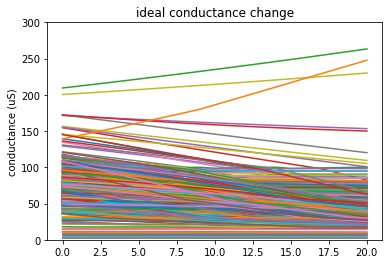

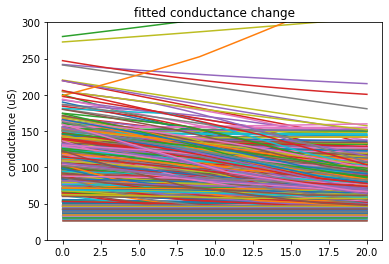

In [16]:
t_p = 0.5e-3 # programming pulse duration
iterations = 20
program_crossbar(crossbar, 0*torch.ones(16,), best_v_bl_applied, t_p, iterations)

After Second Reset voltage

After 2nd reset programming (uS)


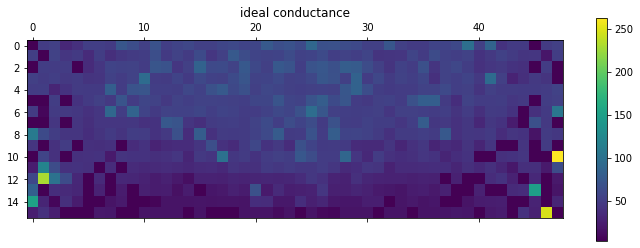

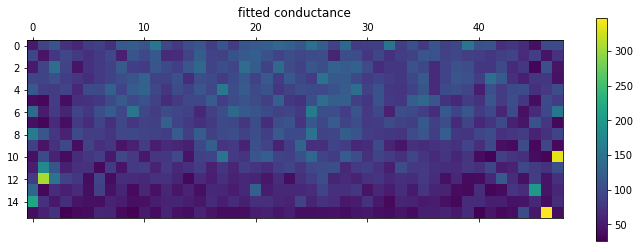

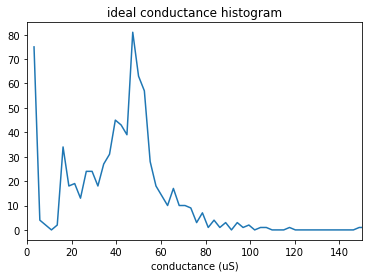

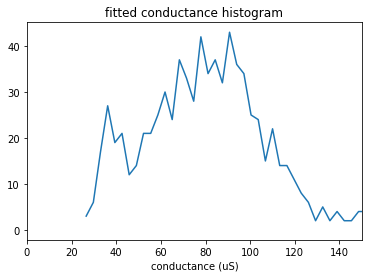

reset in range: 100.0
set in range: 70.83333333333334


In [17]:
crossbar_statistics(crossbar, txt="After 2nd reset programming (uS)")

Second Set voltage

/Users/jvjv/Github/pytorch-metal-oxide-memristor-crossbar/Notebooks/../memristor/devices.py:54: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.g_linfit, _, _, _ = np.linalg.lstsq(np.reshape(np.linspace(-0.4, 0.4, 50), [50,1]),
/Users/jvjv/Github/pytorch-metal-oxide-memristor-crossbar/Notebooks/../memristor/crossbar/model.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ideal_w[i,j] = torch.tensor(self.memristors[i][j].g_0)


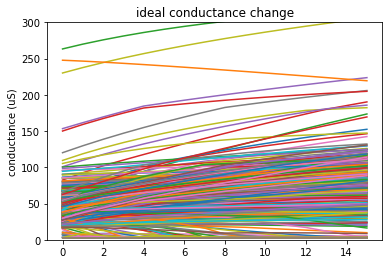

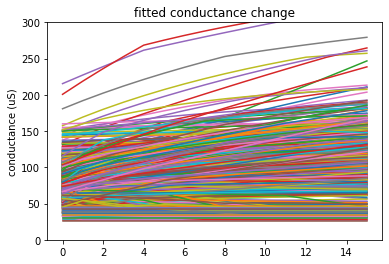

In [18]:
t_p = 0.25e-3 # programming pulse duration
iterations = 15
program_crossbar(crossbar, best_v_wl_applied, 0*torch.ones(48,), t_p, iterations)

After 2nd set programming (uS)


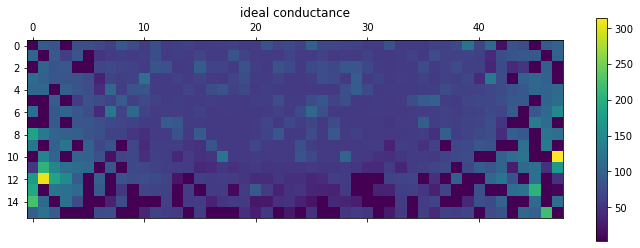

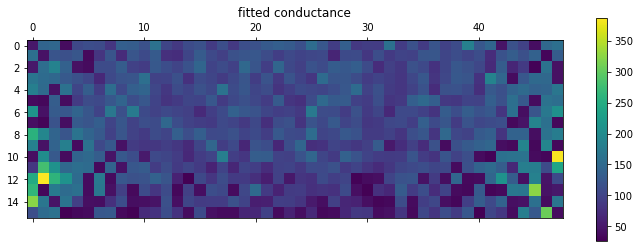

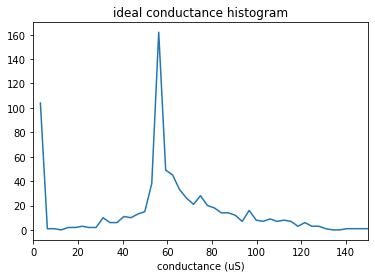

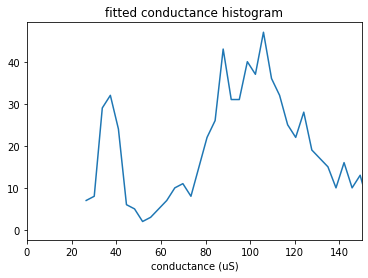

reset in range: 100.0
set in range: 79.55729166666666


In [19]:
crossbar_statistics(crossbar, txt="After 2nd set programming (uS)")

Third reset voltage

/Users/jvjv/Github/pytorch-metal-oxide-memristor-crossbar/Notebooks/../memristor/devices.py:54: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.g_linfit, _, _, _ = np.linalg.lstsq(np.reshape(np.linspace(-0.4, 0.4, 50), [50,1]),
/Users/jvjv/Github/pytorch-metal-oxide-memristor-crossbar/Notebooks/../memristor/crossbar/model.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ideal_w[i,j] = torch.tensor(self.memristors[i][j].g_0)


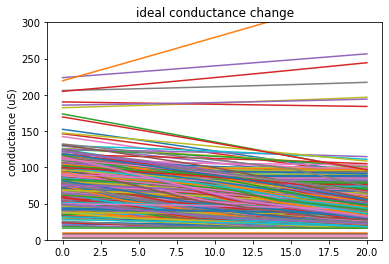

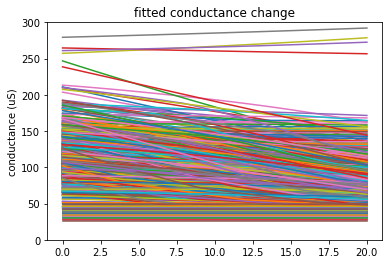

After 3rd reset programming (uS)


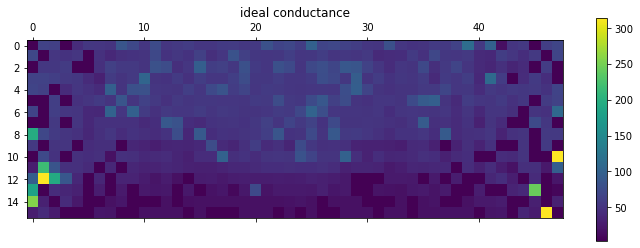

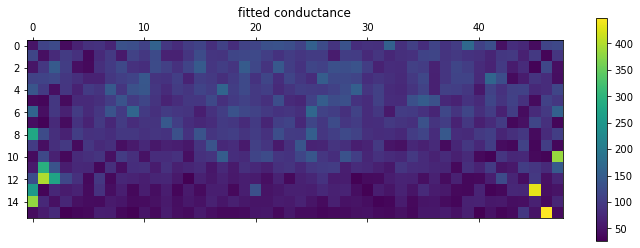

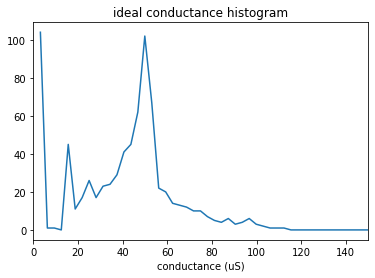

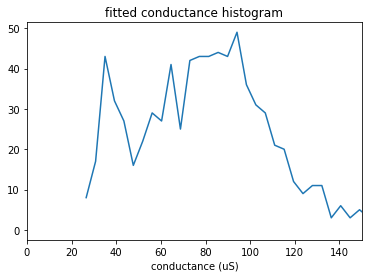

reset in range: 100.0
set in range: 70.44270833333334


In [20]:
t_p = 0.5e-3 # programming pulse duration
iterations = 20
program_crossbar(crossbar, 0*torch.ones(16,), best_v_bl_applied, t_p, iterations)
crossbar_statistics(crossbar, txt="After 3rd reset programming (uS)")

Third set voltage

/Users/jvjv/Github/pytorch-metal-oxide-memristor-crossbar/Notebooks/../memristor/devices.py:54: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  self.g_linfit, _, _, _ = np.linalg.lstsq(np.reshape(np.linspace(-0.4, 0.4, 50), [50,1]),
/Users/jvjv/Github/pytorch-metal-oxide-memristor-crossbar/Notebooks/../memristor/crossbar/model.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.ideal_w[i,j] = torch.tensor(self.memristors[i][j].g_0)


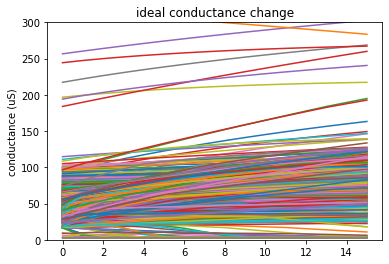

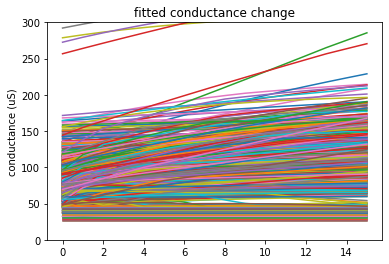

After 3rd set programming (uS)


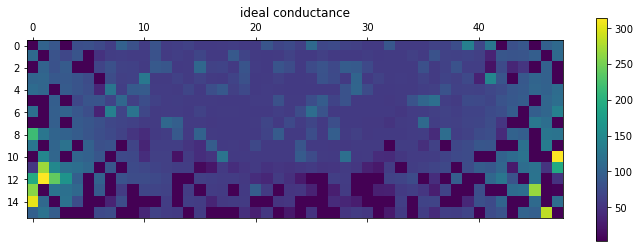

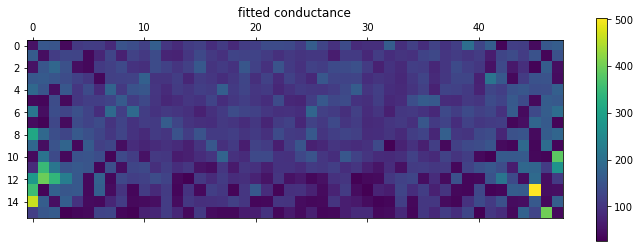

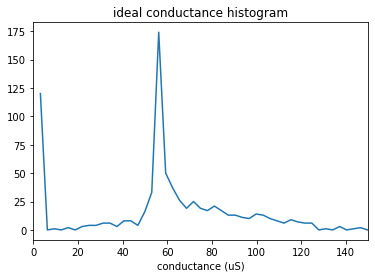

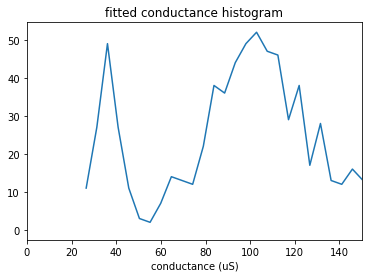

reset in range: 100.0
set in range: 78.25520833333334


In [21]:
t_p = 0.25e-3 # programming pulse duration
iterations = 15
program_crossbar(crossbar, best_v_wl_applied, 0*torch.ones(48,), t_p, iterations)
crossbar_statistics(crossbar, txt="After 3rd set programming (uS)")

## Archive code

##### Monte Carlo Simulation to find best voltage input

In [59]:
n = 200
wl_range = torch.linspace(1.4, 3.0, 16)
bl_range = -torch.linspace(1.5, 3.0, 16)
max_wl, max_bl = 0, 0
best_v_wl_applied = None
best_v_bl_applied = None
for i in tqdm(range(n)):
    v_wl_applied = wl_range[torch.randint(len(wl_range), (16,))]  
    v_bl_applied = wl_range[torch.randint(len(bl_range), (48,))]
    wl = plot_voltage_drop(crossbar, 0*torch.ones(16,), v_bl_applied, imshow=False)
    bl = plot_voltage_drop(crossbar, v_wl_applied, 0*torch.ones(48,), imshow=False)
    if wl > max_wl:
        max_wl = wl
        best_v_wl_applied = torch.clone(v_wl_applied)
    if bl > max_bl:
        max_bl = bl
        best_v_bl_applied = torch.clone(v_bl_applied)
print(f"best percent in range wl voltage: {round(max_wl,2)}%")
print(f"best percent in range bl voltage: {round(max_bl,2)}%")

100%|██████████| 200/200 [04:46<00:00,  1.43s/it]

best percent in range wl voltage: 60.16%
best percent in range bl voltage: 40.49%
